In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cvx.covariance.ewma import iterated_ewma, _ewma_mean
from cvx.covariance.combination import from_sigmas
from cvx.covariance.regularization import regularize_covariance
from experiments.utils.experiment_utils import add_to_diagonal, log_likelihood, ecdf, log_likelihood_sequential, log_likelihood_regularized
from experiments.utils.factor_model import *

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

# Data

In [2]:
# data = pd.read_csv("/Users/kasper/Documents/Stanford/Research/Data/SP500/asset_data_2000_to_2023.csv", index_col=0, parse_dates=True)

# data = data.drop(["TICKER", "PERMCO"], axis=1)
# prices = pd.pivot_table(data, values='PRC', index='date', columns='PERMNO', fill_value=None)
# prices.index = pd.to_datetime(prices.index, format="%Y-%m-%d")
# returns = prices.pct_change().dropna(axis=0, how="all")
returns = 100*pd.read_csv("../data/returns_large_universe.csv", index_col=0, parse_dates=True)

In [3]:
### No mean adjustment
cm_iewma_pairs = [(63, 125), (125, 250), (250, 500), (500, 1000)]

# CM-IEWMA
print("Computing IEWMAs")
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=250)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}
print("Done computing IEWMAs")

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

Computing IEWMAs
Done computing IEWMAs


100%|██████████| 5466/5466 [11:18<00:00,  8.06it/s]  


In [4]:
covariance_no_reg = {result.time: result.covariance for result in results}

In [5]:
print(0)
ll_r1 = log_likelihood_regularized(returns, covariance_no_reg, r=1)

print(1)
ll_r5 = log_likelihood_regularized(returns, covariance_no_reg, r=5)

print(2)
ll_r10 = log_likelihood_regularized(returns, covariance_no_reg, r=10)

print(3)
ll_r20 = log_likelihood_regularized(returns, covariance_no_reg, r=20)

print(4)
ll_r50 = log_likelihood_regularized(returns, covariance_no_reg, r=50)

print(5)
ll_r75 = log_likelihood_regularized(returns, covariance_no_reg, r=75)

print(6)
ll_r100 = log_likelihood_regularized(returns, covariance_no_reg, r=100)

# print(7)
# ll_r150 = log_likelihood_regularized(returns, covariance_no_reg, r=150)

# print(8)
# ll_r238 = log_likelihood_regularized(returns, covariance_no_reg, r=238)

print(9)
ll_no_reg = log_likelihood_regularized(returns, covariance_no_reg, r=None)

0
1
2
3
4
5
6
7


In [60]:
all_lls = [ll_r1, ll_r5, ll_r10, ll_r20, ll_r50, ll_r75, ll_r100, ll_no_reg]

names = ['r=1', 'r=5', 'r=10', 'r=20', 'r=50', 'r=75', 'r=100', 'r=None']

log_likelihoods = {}

for i in range(len(all_lls)):
    log_likelihoods[names[i]] = all_lls[i]

In [83]:
# # Save to csv

# for i, ll in enumerate(all_lls):
#     ll.to_csv(f"results/after_comb_ll_{names[i]}.csv")

In [77]:
start_date = [*covariance_no_reg.keys()][250]
end_date = [*covariance_no_reg.keys()][-1]

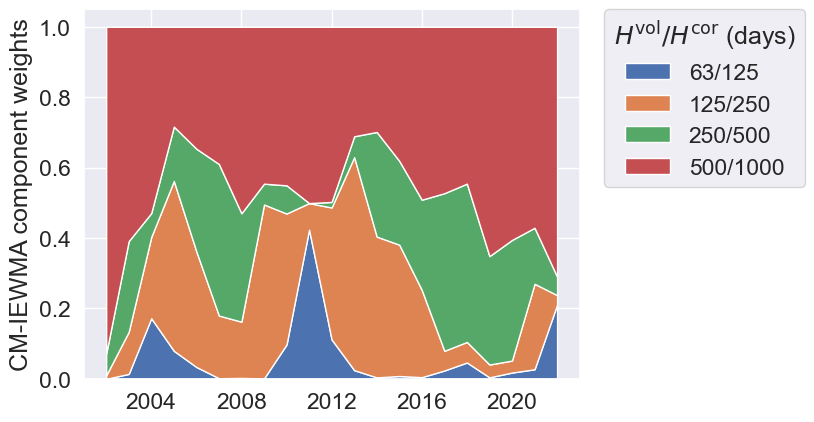

In [14]:
yearly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

# Log-likelihood

Text(0, 0.5, 'Average quarterly log-likelihood')

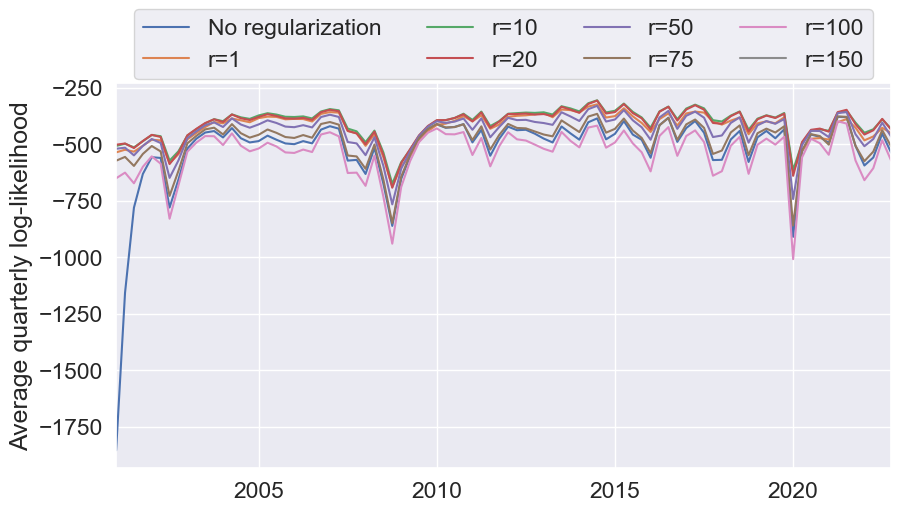

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names[:]:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylabel("Average quarterly log-likelihood")
# plt.ylim(-700,-200);

In [22]:
# Plot average log-likelihood vs r
rs = [1, 10, 20, 50, 75, 100, 238]

avg_log_likelihoods = []
for name in names[:]:
    avg_log_likelihoods.append(log_likelihoods[name].mean())

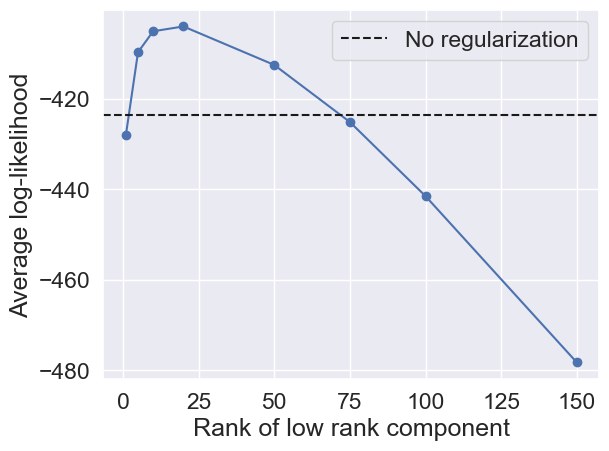

In [95]:
plt.plot(rs[:-1], avg_log_likelihoods[:-1], marker="o");
plt.xlabel("Rank of low rank component")
plt.ylabel("Average log-likelihood");
# Plot horizontal line for no regularization ll_no_reg.mean()
plt.axhline(ll_no_reg.mean(), c="k", ls="--", label="No regularization")
plt.legend();

# Traditional factor model

### No regularization

In [3]:
### No mean adjustment
k = returns.shape[1]
cm_iewma_pairs = [(int(k/2), k), (k, 3*k), (3*k, 6*k)]

# CM-IEWMA
print("Computing IEWMAs")
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=250)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}
print("Done computing IEWMAs")

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

Computing IEWMAs
Done computing IEWMAs


100%|██████████| 5466/5466 [10:45<00:00,  8.47it/s]  


In [4]:
Sigmas = {result.time: result.covariance for result in results}

In [6]:
ll_no_reg = log_likelihood_regularized(returns, Sigmas, r=None)

In [9]:
k=20
cm_iewma_pairs = [(int(k/2), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model20 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [02:19<00:00,  6.36s/it]


In [10]:
ll_20 = factor_log_likelihood(returns, factor_model20)

In [11]:
k=2
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model2 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [01:53<00:00,  5.15s/it]


In [12]:
ll_2 = factor_log_likelihood(returns, factor_model2)

In [13]:
k=5
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model5 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [01:57<00:00,  5.34s/it]


In [14]:
ll_5 = factor_log_likelihood(returns, factor_model5)

In [15]:
k=10
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model10 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [02:05<00:00,  5.70s/it]


In [16]:
ll_10 = factor_log_likelihood(returns, factor_model10)

In [17]:
k=35
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model35 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [02:46<00:00,  7.56s/it]


In [18]:
ll_35 = factor_log_likelihood(returns, factor_model35)

In [19]:
k=50
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model50 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [03:31<00:00,  9.62s/it]


In [20]:
ll_50 = factor_log_likelihood(returns, factor_model50)

In [21]:
k=60
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model60 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

 68%|██████▊   | 15/22 [03:12<01:44, 14.88s/it]

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.


 73%|███████▎  | 16/22 [03:24<01:24, 14.12s/it]

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.


100%|██████████| 22/22 [04:43<00:00, 12.89s/it]


In [22]:
ll_60 = factor_log_likelihood(returns, factor_model60)

/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [23]:
k=75
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model75 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

 77%|███████▋  | 17/22 [03:35<01:15, 15.02s/it]

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.


100%|██████████| 22/22 [04:53<00:00, 13.34s/it]


In [24]:
ll_75 = factor_log_likelihood(returns, factor_model75)

/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [25]:
avg_log_likelihoods = []
avg_log_likelihoods.append(ll_2.mean())
avg_log_likelihoods.append(ll_5.mean())
avg_log_likelihoods.append(ll_10.mean())
avg_log_likelihoods.append(ll_20.mean())
avg_log_likelihoods.append(ll_35.mean())
avg_log_likelihoods.append(ll_50.mean())
avg_log_likelihoods.append(ll_60.mean())
avg_log_likelihoods.append(ll_75.mean())

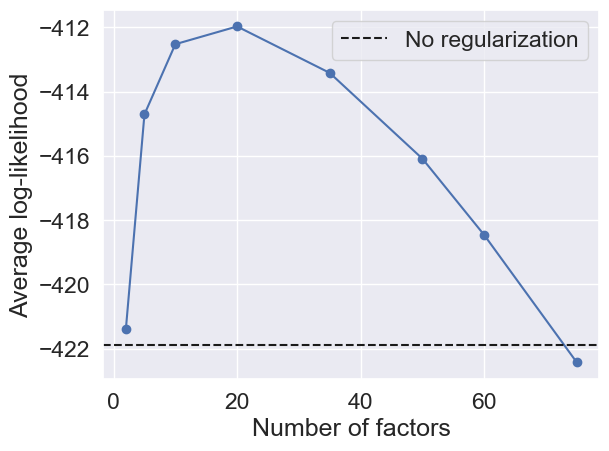

In [28]:
ks = [2, 5, 10, 20, 35, 50, 60, 75]
plt.plot(ks, avg_log_likelihoods, marker="o");
plt.axhline(ll_no_reg.mean(), c="k", ls="--", label="No regularization")
plt.xlabel("Number of factors")
plt.ylabel("Average log-likelihood");
plt.legend();

In [ ]:
ll_75 = factor_log_likelihood(returns, factor_model75)

In [ ]:
k=100
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model100 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

In [ ]:
ll_100 = factor_log_likelihood(returns, factor_model100)

In [ ]:
rs = [1, 10, 20, 50, 75, 100, 238]


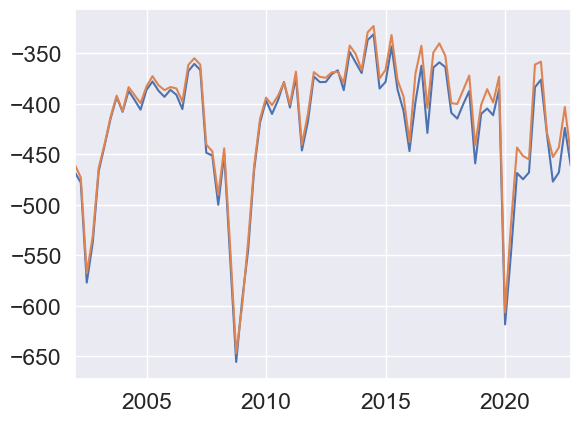

In [252]:
ll_2.resample("Q").mean().plot()
ll_20.resample("Q").mean().plot();

In [ ]:
ll_2.to_csv(f"results/factor_ll_2.csv")
ll_5.to_csv(f"results/factor_ll_5.csv")
ll_10.to_csv(f"results/factor_ll_10.csv")
ll_20.to_csv(f"results/factor_ll_20.csv")
ll_35.to_csv(f"results/factor_ll_35.csv")
ll_50.to_csv(f"results/factor_ll_50.csv")
ll_60.to_csv(f"results/factor_ll_60.csv")
ll_75.to_csv(f"results/factor_ll_75.csv")


In [29]:
ll_100

NameError: name 'll_100' is not defined